In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('diabetes_data.csv')
print('First 5 rows:\n', data.head())
print('\nThe size of the dataset: ', data.shape)
print('\nData types for each column:\n', data.dtypes)
print('\nStats for the dataset:\n', data.describe())

First 5 rows:
    age  gender    bmi bmi_category  systolic  diastolic  \
0   55  Female  29.59   Overweight     112.0       89.5   
1   34    Male  30.68      Obesity     106.0      115.0   
2   26    Male  15.96  Underweight      96.0       97.0   
3   63    Male  15.61  Underweight     109.6      115.3   
4   37    Male  41.54      Obesity     110.0      103.0   

  blood_pressure_category  cholesterol cholesterol_category  glucose  \
0    Hypertension Stage 1          247                 High      139   
1    Hypertension Stage 2          255                 High      101   
2    Hypertension Stage 2          234      Borderline high       97   
3    Hypertension Stage 2          261                 High      143   
4    Hypertension Stage 2          226      Borderline high      115   

   diabetes_probability  
0                  0.65  
1                  0.60  
2                  0.15  
3                  0.70  
4                  0.50  

The size of the dataset:  (10000, 11)

D

In [3]:
# Check if there are not empty values
print('\nCheck for empty values:\n', data.isnull())
print('\nTotal number of empty values for each column:\n', data.isnull().sum())


Check for empty values:
         age  gender    bmi  bmi_category  systolic  diastolic  \
0     False   False  False         False     False      False   
1     False   False  False         False     False      False   
2     False   False  False         False     False      False   
3     False   False  False         False     False      False   
4     False   False  False         False     False      False   
...     ...     ...    ...           ...       ...        ...   
9995  False   False  False         False     False      False   
9996  False   False  False         False     False      False   
9997  False   False  False         False     False      False   
9998  False   False  False         False     False      False   
9999  False   False  False         False     False      False   

      blood_pressure_category  cholesterol  cholesterol_category  glucose  \
0                       False        False                 False    False   
1                       False        Fa

In [4]:
# Function for grouping data based on probability intervals
def group_by_probability_intervals(dataFrame, interval_size = 0.1):
    intervals = [f"{i:.1f} - {i + interval_size:.1f}" for i in range(0, 10)]
    counts = []

    for i in range(len(intervals)):
        lower_bound = i * interval_size
        upper_bound = (i + 1) * interval_size
        count = len(dataFrame[(dataFrame['diabetes_probability'] >= lower_bound) & (dataFrame['diabetes_probability'] < upper_bound)])
        counts.append(count)

    return intervals, counts

intervals, counts = group_by_probability_intervals(data, interval_size = 0.1)

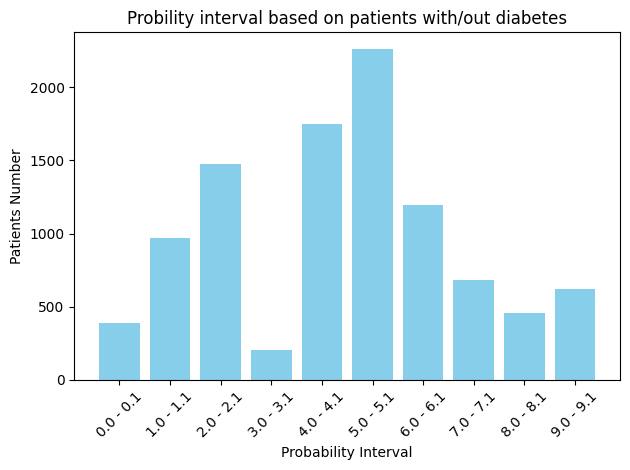

In [5]:
# Show the graph
plt.bar(intervals, counts, color = 'skyblue')
plt.title('Probility interval based on patients with/out diabetes')
plt.xlabel('Probability Interval')
plt.ylabel('Patients Number')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [6]:
# Function for selecting rows based on probabilities
# Let's divide the dataset to see who have diabetes or not
# 0 < 0.5 < 1

def select_by_probability(dataFrame, value):
    above_value = dataFrame[dataFrame['diabetes_probability'] > value]
    below_value = dataFrame[dataFrame['diabetes_probability'] < value]
    return above_value, below_value

above_05, below_05 = select_by_probability(data, 0.5)

In [7]:
# How many have diabetes and how many doesn't have
num_with_diabetes = len(above_05)
num_without_diabetes = len(below_05)

print(f"The number of patients who have diabetes (>0.5):", {num_with_diabetes})
print(f"The number of patients who don't have diabetes (<0.5):" , {num_without_diabetes})

The number of patients who have diabetes (>0.5): {4734}
The number of patients who don't have diabetes (<0.5): {4787}


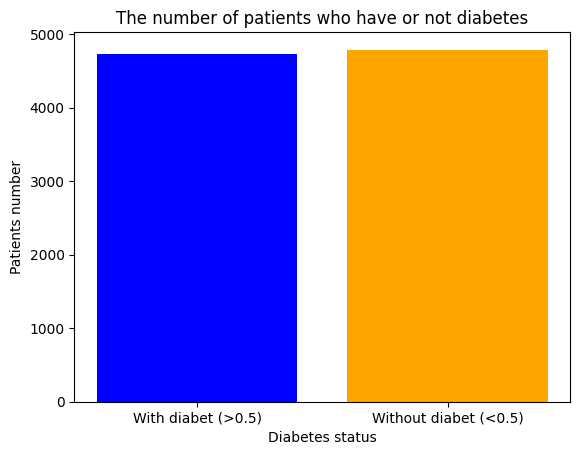

In [8]:
# Graph for who have diabetes or not
labels = ['With diabet (>0.5)', 'Without diabet (<0.5)']
values = [num_with_diabetes, num_without_diabetes]

plt.bar(labels, values, color = ['blue', 'orange'])
plt.title('The number of patients who have or not diabetes')
plt.xlabel('Diabetes status')
plt.ylabel('Patients number')
plt.show()

In [9]:
# One-Hot Encoding for the 'gender' column, keeping only one category (Male)
data['gender_encoded'] = data['gender'].map({'Female': 0, 'Male': 1})

# Mapping the 'bmi_category' to numerical values (ordinal encoding)
bmi_map = {'Underweight': 1, 'Normal weight': 2, 'Overweight': 3, 'Obesity': 4}
data['bmi_category_encoded'] = data['bmi_category'].map(bmi_map)

# Mapping the 'blood_pressure_category' to numerical values (ordinal encoding)
bp_map = {
    'Normal': 1,
    'Elevated': 2,
    'Hypertension Stage 1': 3,
    'Hypertension Stage 2': 4,
    'Hypertensive Crisis': 5
}
data['blood_pressure_category_encoded'] = data['blood_pressure_category'].map(bp_map)

# Mapping the 'cholesterol_category' to numerical values (ordinal encoding)
cholesterol_map = {'Normal': 1, 'Borderline high': 2, 'High': 3}
data['cholesterol_category_encoded'] = data['cholesterol_category'].map(cholesterol_map)

In [10]:
# Drop the original columns that were encoded
data = data.drop(columns=['gender', 'bmi_category', 'blood_pressure_category', 'cholesterol_category'])

# Show the first 5 rows and the size of the dataset
print('\nShow first 5 rows: ', data.head())
print('\nShow the size of the data set: ', data.shape)


Show first 5 rows:     age    bmi  systolic  diastolic  cholesterol  glucose  \
0   55  29.59     112.0       89.5          247      139   
1   34  30.68     106.0      115.0          255      101   
2   26  15.96      96.0       97.0          234       97   
3   63  15.61     109.6      115.3          261      143   
4   37  41.54     110.0      103.0          226      115   

   diabetes_probability  gender_encoded  bmi_category_encoded  \
0                  0.65               0                     3   
1                  0.60               1                     4   
2                  0.15               1                     1   
3                  0.70               1                     1   
4                  0.50               1                     4   

   blood_pressure_category_encoded  cholesterol_category_encoded  
0                                3                             3  
1                                4                             3  
2                         

In [11]:
# New data columns
new_data_columns = ['age', 'gender_encoded', 'bmi', 'bmi_category_encoded', 'systolic', 'diastolic', 
                    'blood_pressure_category_encoded', 'cholesterol', 'cholesterol_category_encoded', 'glucose', 'diabetes_probability']
new_data = data[new_data_columns]

print('\nShow first 5 rows: ', new_data.head())
print('\nShow the size of the data set: ', new_data.shape)
print('\nShow the data types for each column: ', new_data.dtypes)


Show first 5 rows:     age  gender_encoded    bmi  bmi_category_encoded  systolic  diastolic  \
0   55               0  29.59                     3     112.0       89.5   
1   34               1  30.68                     4     106.0      115.0   
2   26               1  15.96                     1      96.0       97.0   
3   63               1  15.61                     1     109.6      115.3   
4   37               1  41.54                     4     110.0      103.0   

   blood_pressure_category_encoded  cholesterol  cholesterol_category_encoded  \
0                                3          247                             3   
1                                4          255                             3   
2                                4          234                             2   
3                                4          261                             3   
4                                4          226                             2   

   glucose  diabetes_probability  


In [12]:
# Verify
print(new_data[['gender_encoded', 'bmi_category_encoded', 'blood_pressure_category_encoded', 'cholesterol_category_encoded']].head())

   gender_encoded  bmi_category_encoded  blood_pressure_category_encoded  \
0               0                     3                                3   
1               1                     4                                4   
2               1                     1                                4   
3               1                     1                                4   
4               1                     4                                4   

   cholesterol_category_encoded  
0                             3  
1                             3  
2                             2  
3                             3  
4                             2  


In [13]:
# Now let's find if our dataset is asymmetry or symmetry
# If asymmetry is near 0, the distribution is symmetric
# asymmetry > 1, the distribution is asymmetric to right
# asymmetry < -1, the distribution is asymmetric to left

# First, we use the pandas to find asym.
numeric_columns = ['age', 'gender_encoded', 'bmi', 'bmi_category_encoded', 'systolic', 'diastolic', 
                    'blood_pressure_category_encoded', 'cholesterol', 'cholesterol_category_encoded', 'glucose', 'diabetes_probability']
for col in numeric_columns:
    print(f"The asymmetry for {col} : {skew(new_data[col])}")

The asymmetry for age : -0.008867489152858593
The asymmetry for gender_encoded : 0.022401405060189516
The asymmetry for bmi : 0.5901396552326016
The asymmetry for bmi_category_encoded : -0.06384558667161835
The asymmetry for systolic : 0.01813768459870944
The asymmetry for diastolic : -0.004166823425661909
The asymmetry for blood_pressure_category_encoded : -0.984119584451413
The asymmetry for cholesterol : 0.0088515414471291
The asymmetry for cholesterol_category_encoded : -0.2998683171603659
The asymmetry for glucose : 0.0027261079497222745
The asymmetry for diabetes_probability : -0.18555222980336333


Text(0.5, 1.0, 'Histogram for BMI (Before Log Transformation)')

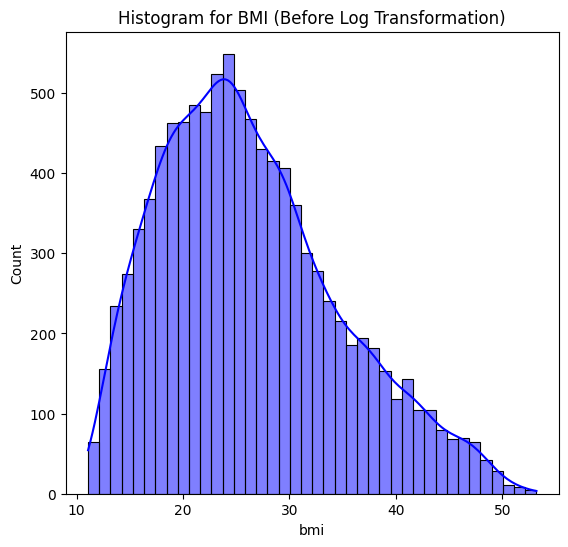

In [14]:
# BMI has an asymmetry of 0.59
# Graph for BMI
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot histogram before transformation
plt.subplot(1, 2, 1)
sns.histplot(new_data['bmi'], kde=True, color='blue')
plt.title('Histogram for BMI (Before Log Transformation)')

In [15]:
# BMI has an asymmetry of 0.59
# We apply a logarithmic transformation
new_data['bmi'] = np.log1p(new_data['bmi'])
print(new_data.head())

   age  gender_encoded       bmi  bmi_category_encoded  systolic  diastolic  \
0   55               0  3.420673                     3     112.0       89.5   
1   34               1  3.455686                     4     106.0      115.0   
2   26               1  2.830858                     1      96.0       97.0   
3   63               1  2.810005                     1     109.6      115.3   
4   37               1  3.750445                     4     110.0      103.0   

   blood_pressure_category_encoded  cholesterol  cholesterol_category_encoded  \
0                                3          247                             3   
1                                4          255                             3   
2                                4          234                             2   
3                                4          261                             3   
4                                4          226                             2   

   glucose  diabetes_probability  
0  

In [16]:
# Check again the asymmetry
for col in numeric_columns:
    print(f"The asymmetry for {col} : {skew(new_data[col])}")

The asymmetry for age : -0.008867489152858593
The asymmetry for gender_encoded : 0.022401405060189516
The asymmetry for bmi : -0.05223485298571843
The asymmetry for bmi_category_encoded : -0.06384558667161835
The asymmetry for systolic : 0.01813768459870944
The asymmetry for diastolic : -0.004166823425661909
The asymmetry for blood_pressure_category_encoded : -0.984119584451413
The asymmetry for cholesterol : 0.0088515414471291
The asymmetry for cholesterol_category_encoded : -0.2998683171603659
The asymmetry for glucose : 0.0027261079497222745
The asymmetry for diabetes_probability : -0.18555222980336333


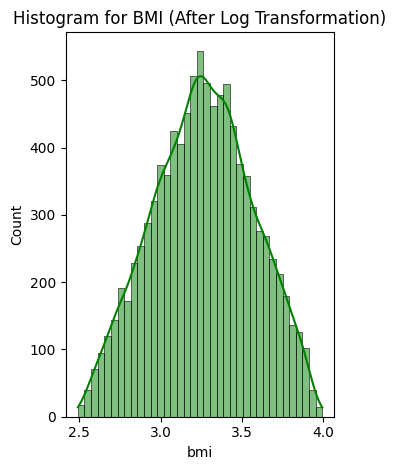

In [17]:
# Plot histogram after transformation
plt.subplot(1, 2, 2)
sns.histplot(new_data['bmi'], kde=True, color='green')
plt.title('Histogram for BMI (After Log Transformation)')

plt.tight_layout()
plt.show()

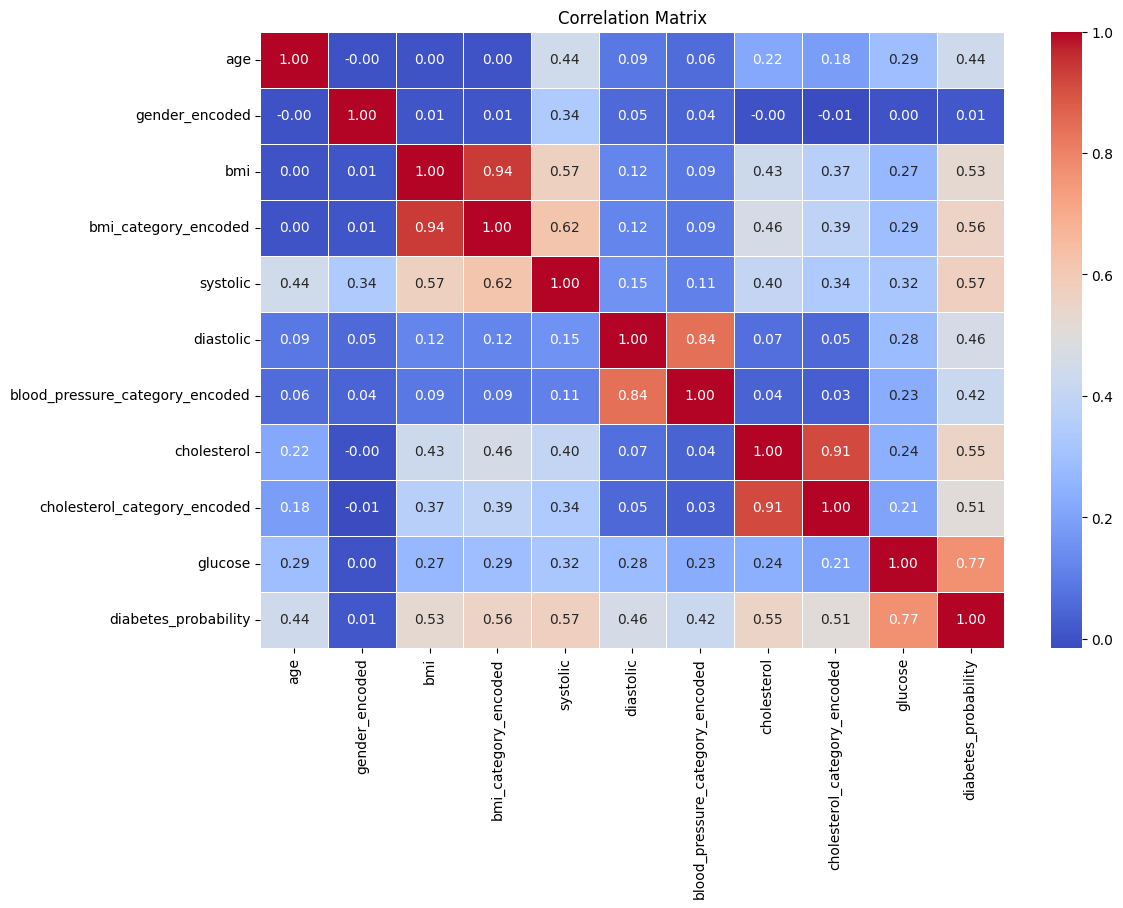

In [18]:
# Correlation matrix
correlation_matrix = new_data[numeric_columns].corr()

# Show the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Seems we have a critical correlation
# Let's remove some variables
new_data = new_data.drop(columns = ['bmi_category_encoded', 'cholesterol_category_encoded', 'blood_pressure_category_encoded'])
print(new_data.head())

   age  gender_encoded       bmi  systolic  diastolic  cholesterol  glucose  \
0   55               0  3.420673     112.0       89.5          247      139   
1   34               1  3.455686     106.0      115.0          255      101   
2   26               1  2.830858      96.0       97.0          234       97   
3   63               1  2.810005     109.6      115.3          261      143   
4   37               1  3.750445     110.0      103.0          226      115   

   diabetes_probability  
0                  0.65  
1                  0.60  
2                  0.15  
3                  0.70  
4                  0.50  


In [20]:
# Updated the dataset with the remains columns
numeric_columns_updated = ['age', 'gender_encoded', 'bmi', 'systolic', 'diastolic', 'cholesterol', 'glucose', 'diabetes_probability']
new_data = new_data[numeric_columns_updated]

In [21]:
# Let's check the VIF for the new dataset
# We ignore the const and diabetes_probability variables
X = add_constant(new_data)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

               Variable         VIF
0                 const  739.995611
1                   age    1.849955
2        gender_encoded    1.326006
3                   bmi    2.363222
4              systolic    2.850366
5             diastolic    1.593024
6           cholesterol    1.853883
7               glucose    3.314797
8  diabetes_probability    8.001460


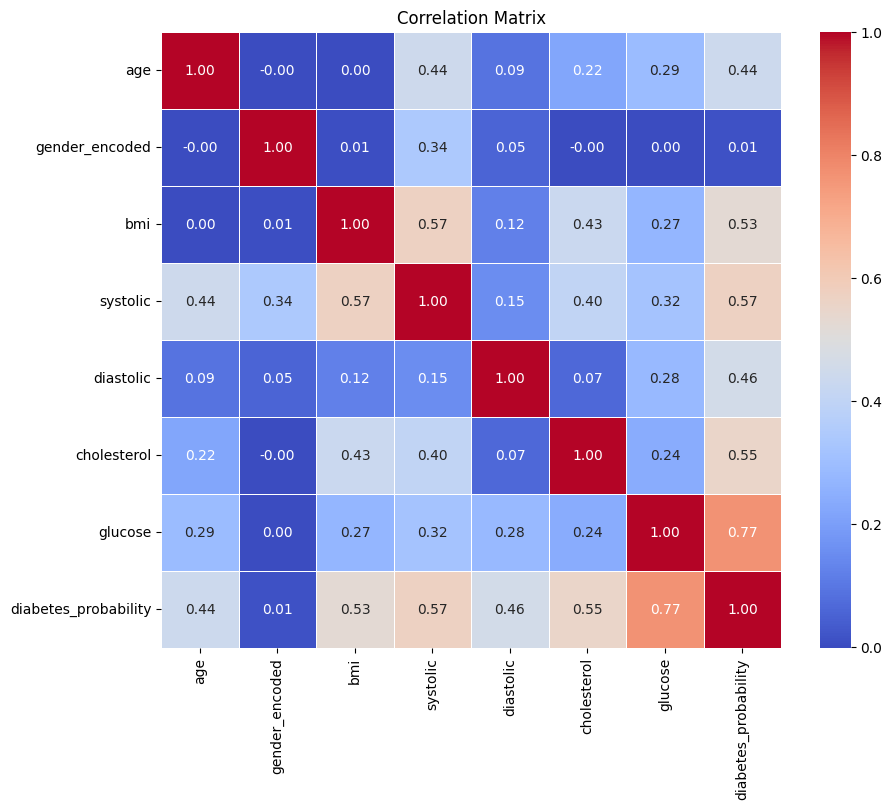

In [22]:
# Checking for correlation matrix again
correlation_matrix = new_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [23]:
# Data preparation
# Remove unnecessary columns
X = new_data[['age', 'gender_encoded', 'bmi', 'systolic', 'diastolic', 'cholesterol', 'glucose']]
y = new_data['diabetes_probability']

In [24]:
# Split data into training and test sets
y_binary = (y >= 0.5).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [25]:
# Data standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Implementation of logistic regression with Gradient Descent
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X.dot(theta))
    cost = (-1/m) * (y.dot(np.log(h)) + (1 - y).dot(np.log(1 - h)))
    return cost

def gradient_descent(X, y, theta, learning_rate=0.01, iterations=5000):
    m = len(y)
    cost_history = np.zeros(iterations)
    
    for i in range(iterations):
        h = sigmoid(X.dot(theta))
        gradient = (1/m) * X.T.dot(h - y)
        theta -= learning_rate * gradient
        cost_history[i] = compute_cost(X, y, theta)
    
    return theta, cost_history

In [27]:
# Add a constants column for logistic regression
X_train_scaled_with_const = add_constant(X_train_scaled)
X_test_scaled_with_const = add_constant(X_test_scaled)

In [28]:
# Initialize parameters
theta_initial = np.zeros(X_train_scaled_with_const.shape[1])

In [29]:
# Apply gradient descent
theta_optimal, cost_history = gradient_descent(X_train_scaled_with_const, y_train, theta_initial, learning_rate=0.01, iterations=5000)

In [30]:
# Predictions with the logistic regression model
y_pred_log_reg = sigmoid(X_test_scaled_with_const.dot(theta_optimal)) >= 0.5

In [31]:
# Evaluation for logistic regression
accuracy = accuracy_score(y_test, y_pred_log_reg)
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)
class_report = classification_report(y_test, y_pred_log_reg)

In [32]:
# Evaluation for logistic regression on the training set
y_pred_train = sigmoid(X_train_scaled_with_const.dot(theta_optimal)) >= 0.5
accuracy_train = accuracy_score(y_train, y_pred_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
class_report_train = classification_report(y_train, y_pred_train)

In [33]:
# We display the results
print(f"\nAccuracy of Logistic Regression (Gradient Descent): {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"\nAccuracy on Training Set: {accuracy_train}")
print(f"Confusion Matrix (Training Set):\n{conf_matrix_train}")
print(f"Classification Report (Training Set):\n{class_report_train}")


Accuracy of Logistic Regression (Gradient Descent): 0.9045
Confusion Matrix:
[[847  92]
 [ 99 962]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       939
           1       0.91      0.91      0.91      1061

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000


Accuracy on Training Set: 0.914125
Confusion Matrix (Training Set):
[[3511  337]
 [ 350 3802]]
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3848
           1       0.92      0.92      0.92      4152

    accuracy                           0.91      8000
   macro avg       0.91      0.91      0.91      8000
weighted avg       0.91      0.91      0.91      8000



In [34]:
# We calculate the AUC for the test set
auc = roc_auc_score(y_test, y_pred_log_reg)
print(f"AUC: {auc}")

AUC: 0.90435761468424


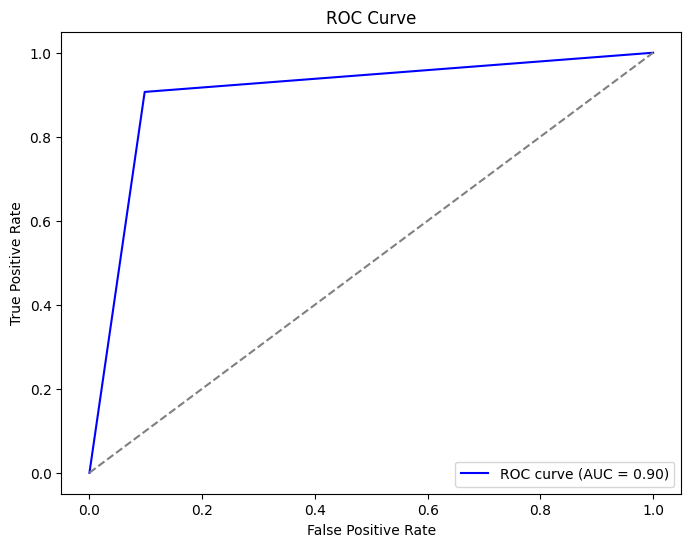

In [35]:
# We generate ROC curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()